# 프로젝트 :ResNet Ablation Study

### 1) ResNet 기본 블록 구성하기

In [1]:
# TensorFlow and tf.keras & # Helper libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

dataset_name = 'cats_vs_dogs'
ds_train, ds_info_train = tfds.load(name=dataset_name, split='train[:80%]', as_supervised=True, with_info=True)
ds_valid, ds_info_valid = tfds.load(name=dataset_name, split='train[80%:]', as_supervised=True, with_info=True)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info_train.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [20]:
# label 확인
ds_info_train.features["label"].num_classes
ds_info_valid.features["label"].names

['cat', 'dog']

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
def conv1(x): 
    # Conv2D
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        kernel_initializer='he_normal',
        padding='same', name='conv2d_7x7'
    )(x)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    # maxpooling
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2,
             name='stage2_0_maxpooling'
            )(x)
    
    return x

    # residual 통과(layer-18,34): 1*1 conv2d stride2 -> BN
def conv_short(x,filters,stage_num,block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(2,2),
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

    # residual 통과(layer-50,101,152): 1*1 conv2d stride1 -> BN
def conv_short50(x,filters, stage_num, block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(1,1), 
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn4')(x)
    
    return x

### 2) ResNet-34, ResNet-50 Complete Model

In [8]:
def conv_master1(x,
                 first_layer,
                 block_num,
                 kernel_size,
                 filters,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    """
    conv2
    1) layer-18: [[3*3],64, [3*3],64]*2
    2) layer-34: [[3*3],64, [3*3],64]*3
    3) layer-50: [[1*1],64, [3*3],64, [1*1],256]
    """
    
    # residual 정의
    residual = x
    
    if num_layer == 18 or num_layer == 34:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv2'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        
        if not is_plain:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    else:
        # 3개 층 중에서 첫번째 층만 shortcut이고 나머지 두 개는 입력값을 그대로 사용
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[0],
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[1],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters*4, # 마지막 레이어는 4배이다.
            kernel_size=kernel_size[2],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv3',
            padding='same'
        )(x)
        
        # short
        conv3_short = conv_short50(residual, filters=filters*4, stage_num=stage_num, block_num=block_num)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn3')(x)
        
        if not is_plain:
            if first_layer:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
            else:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])
            
        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

In [9]:
# conv3_x ~ conv5_x 블럭
def conv_master2(x,
                 block_num,
                 kernel_size,
                 filters,
                 first_layer, # True/False,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    
    residual = x
    
    # kernel_size_copy
    if num_layer == 50 or num_layer == 101 or num_layer == 152:
        kernel_size_copy = kernel_size.copy()
        kernel_size = kernel_size_copy[0]
        
    # <!-- first block --!>    
    # 첫 번재 층은 stride를 해야 함.
    if first_layer:
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', strides=(2,2), # stride
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    else:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    if num_layer==50 or num_layer==101 or num_layer==152: 
        # <!-- second block --!>
        kernel_size = kernel_size_copy[1]
#         print(f'stage{stage_num}_{block_num+1}_conv2')
#         print('kernel_size: ', kernel_size)
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
    
    
    # <!-- third block --!>
#     print(f'stage{stage_num}_{block_num+1}_conv2')
#     print('kernel_size: ', kernel_size)
    conv_num=3
    if num_layer==50 or num_layer==101 or num_layer==152:
        filters=filters*4
        kernel_size = kernel_size_copy[2]
    else: conv_num-=1
    
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv{conv_num}',
        padding='same'
    )(x)

    # short
    conv3_short = conv_short(residual, filters, stage_num=stage_num, block_num=block_num)
    conv3_short50 = conv_short50(residual, filters, stage_num=stage_num, block_num=block_num)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn{conv_num}')(x)
    
    if not is_plain:
        if first_layer:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
        else:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

    # activation
    x = tf.keras.layers.Activation('relu')(x)

    return x

#### building ResNet Block

In [10]:
def build_resnet(input_layer, num_layer=34, is_residual=True, is_plain=False):
    
    # layer개수에 따른 cnn층 개수
    cnn_layer ={
                18 : [2,2,2,2], 
                34 : [3,4,6,3], 
                50 : [3,4,6,3], 
                101 : [3,4,23,3],
                152 : [3,8,36,3]
                }
    
    # layer개수에 따른 filter 리스트
    filter_list = [64, 128, 256, 512]
    
    # layer별 커널 사이즈
    kernel_size_dict = {18:(3,3),
                   34:(3,3),
                   50:[(1,1),(3,3),(1,1)],
                   101:[(1,1),(3,3),(1,1)],
                   152:[(1,1),(3,3),(1,1)]}
    
    # layer별 커널 사이즈
    kernel_size = kernel_size_dict[num_layer]
    
    # cnn층 블록 개수 리스트(num_cnn_list) 할당
    num_cnn_list = cnn_layer[num_layer]
    
    # 전체 conv 블록 개수
    num_conv = len(num_cnn_list)
    
    # 입력 레이어
    x = input_layer
    
    # 7*7, 64, stride2 + maxpooling
    x = conv1(x)
    
    # stage num 정의
    stage_num = 2
    
    # conv_idx 정의
    conv_idx=0

    # conv2_x
    
    # layer-50,101,152만 해당
    first_layer = [True,False,False]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master1(x,
                         first_layer=first_layer[i],
                         block_num=i,
                         kernel_size=kernel_size,
                         filters=filter_list[conv_idx],
                         stage_num=stage_num,
                         num_layer=num_layer,
                         is_plain=is_plain
                         )
#     print('conv2 완료')

    # conv3_x
    stage_num+=1
    conv_idx+=1
    if is_residual: # residual 있을때
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:          # residual 없을때
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
        
#     print('conv3 완료')

    # conv4_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
#     print('first_layer: ',first_layer)
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv4 완료')
    # conv5_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv5 완료')

    # avg pooling
    x= keras.layers.AveragePooling2D(
        pool_size=(2, 2), strides=2, padding='SAME', name='avg_pool')(x)
    
    # flatten
    x = keras.layers.Flatten(name='flatten_11')(x)
    
    # FC layer(2) --- 우리가 사용할 데이터는 '고양이', '개' 두 가지 클래스만 있으므로 이걸 사용해야함.
    x = keras.layers.Dense(2,name='fc2')(x)
    
    # FC layer(10) --- 노드의 파라미터 확인용(cifar-10일 때는 이것을 사용해야함) 확인이 끝난 후에는 다시 주석 처리했음.
#     x = keras.layers.Dense(10,name='fc2')(x)
    
    return x

In [19]:
### 3) ResNet-34, ResNet-50 Model 학습 및 시각화

In [13]:
BATCH_SIZE = 16
EPOCH = 20

# 데이터 정의
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE)

In [14]:
resnet34_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')  
resnet34_block_output = build_resnet(resnet34_input_layer)


resnet34 = keras.Model(inputs=resnet34_input_layer, outputs=resnet34_block_output)
resnet34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 112, 112, 64) 256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [15]:
# ResNet-34 학습
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 143s 105ms/step - loss: 0.7820 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5306
Epoch 2/20
1163/1163 [==============================] - 100s 86ms/step - loss: 1.2310 - accuracy: 0.5450 - val_loss: 2.3061 - val_accuracy: 0.6011
Epoch 3/20
1163/1163 [==============================] - 104s 89ms/step - loss: 2.5957 - accuracy: 0.5932 - val_loss: 3.1123 - val_accuracy: 0.6130
Epoch 4/20
1163/1163 [==============================] - 108s 93ms/step - loss: 3.4664 - accuracy: 0.6045 - val_loss: 1.0049 - val_accuracy: 0.5328
Epoch 5/20
1163/1163 [==============================] - 108s 93ms/step - loss: 2.6019 - accuracy: 0.6227 - val_loss: 2.0505 - val_accuracy: 0.6338
Epoch 6/20
1163/1163 [==============================] - 104s 89ms/step - loss: 3.1077 - accuracy: 0.6243 - val_loss: 5.1045 - val_accuracy: 0.5895
Epoch 7/20
1163/1163 [==============================] - 104s 89ms/step - loss: 3.9322 - accuracy: 0.6112 - val_loss: 

In [16]:
#resnet50 모델 
resnet50_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
resnet50_block_output = build_resnet(resnet50_input_layer, num_layer=50) # num_layer 설정

resnet50 = keras.Model(inputs=resnet50_input_layer, outputs=resnet50_block_output)
resnet50.summary()

[0]               
__________________________________________________________________________________________________
stage2_3_conv3 (Conv2D)         (None, 56, 56, 256)  16640       activation_123[0][0]             
__________________________________________________________________________________________________
stage2_3_bn3 (BatchNormalizatio (None, 56, 56, 256)  1024        stage2_3_conv3[0][0]             
__________________________________________________________________________________________________
stage2_3_add (Add)              (None, 56, 56, 256)  0           stage2_3_bn3[0][0]               
                                                                 activation_121[0][0]             
__________________________________________________________________________________________________
activation_124 (Activation)     (None, 56, 56, 256)  0           stage2_3_add[0][0]               
__________________________________________________________________________________________

In [17]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 212s 148ms/step - loss: 0.7282 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.4886
Epoch 2/20
1163/1163 [==============================] - 210s 181ms/step - loss: 0.6931 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.4944
Epoch 3/20
1163/1163 [==============================] - 172s 148ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.4981
Epoch 4/20
1163/1163 [==============================] - 170s 146ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/20
1163/1163 [==============================] - 176s 152ms/step - loss: 0.6931 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 6/20
1163/1163 [==============================] - 177s 152ms/step - loss: 0.6931 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.4836
Epoch 7/20
1163/1163 [==============================] - 179s 154ms/step - loss: 0.6931 - accuracy: 0.5056 - val_

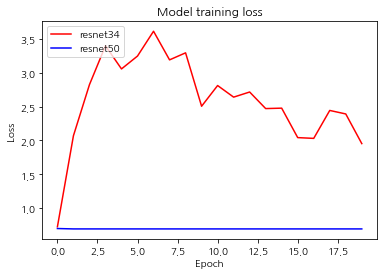

In [18]:
# resnet34 vs resnet 50 학습 loss 시각화
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper left')
plt.show()

# 프로젝트를 마치며...

#### 모델을 실제로 구성해보고 하나하나 검색하며 알아보는 시간이였다 하지만 loss 들은 줄어들지 않네요... 어디서 문제 인지 잘모르겠다 나의 이해력이 부족인가... 알면 알수록 더 어려운 딥러닝 ResNet34,50을 구현을 해본거에 의미를 두기로 했다...